In [244]:
import requests as rq
from bs4 import BeautifulSoup as bs
import json
import datetime as dt
import pandas as pd
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
import math

#pip install --upgrade pip
#pip install tensorflow
#pip install -U tensorflow

import keras
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [245]:
# LSTM XOM

In [246]:
#link times series daily adjusted XOM
headers = {"User-Agent" : "Mozilla/5.0 (Macintosh; Intel Mac OS X 13_0_1) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.1 Safari/605.1.15"}

API_KEY = "LGCD1MSA9W87BCVR"
url_base = "https://www.alphavantage.co"

# unix timestamp : le nombre de seconde passée de puis le 1 Janvier 1970 00:00:00

url_suite = "/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=XOM&outputsize=full&apikey=API_KEY"

full_url = url_base + url_suite
print(full_url)

https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=XOM&outputsize=full&apikey=API_KEY


In [247]:
#extract times series daily adjusted XOM
respXOM = rq.get(full_url, headers=headers).json()
testXOM = respXOM['Time Series (Daily)']
days = list(testXOM.keys())

adjustedcloseXOM = [testXOM[i]['5. adjusted close'] for i in testXOM]

dfXOM = pd.DataFrame(columns=['Date','AdjustedcloseXOM'])
dfXOM.iloc[:,0] = days
dfXOM.iloc[:,1] = adjustedcloseXOM
dfXOM = dfXOM.iloc[:2540,]
dfXOM

,Date,AdjustedcloseXOM
0,2023-02-03,111.92
1,2023-02-02,111.15
2,2023-02-01,114.74
3,2023-01-31,116.01
4,2023-01-30,113.56
...,...,...
2535,2013-01-09,57.6601703975317
2536,2013-01-08,57.8825944721308
2537,2013-01-07,57.5227908220441
2538,2013-01-04,58.1966049303882


In [248]:
#reverse the rows of the dataset
dfXOM = dfXOM[::-1]
dfXOM

,Date,AdjustedcloseXOM
2539,2013-01-03,57.92838766396
2538,2013-01-04,58.1966049303882
2537,2013-01-07,57.5227908220441
2536,2013-01-08,57.8825944721308
2535,2013-01-09,57.6601703975317
...,...,...
4,2023-01-30,113.56
3,2023-01-31,116.01
2,2023-02-01,114.74
1,2023-02-02,111.15


In [249]:
# Split the sample into training and test sets
training_set = dfXOM.iloc[:2081, 1:2].values # we want to plot 459 predicted values so 2540-459 = 2081 is the splitting row
test_set = dfXOM.iloc[2081:, 1:2].values # test_size = 459/2540 = 18% 

In [250]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, 2081):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#X_train.shape #(2021, 60, 1)

In [251]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))
# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
64/64 [==============================] - 17s 92ms/step - loss: 0.0554
Epoch 2/100
64/64 [==============================] - 5s 77ms/step - loss: 0.0094
Epoch 3/100
64/64 [==============================] - 4s 67ms/step - loss: 0.0085
Epoch 4/100
64/64 [==============================] - 5s 75ms/step - loss: 0.0084
Epoch 5/100
64/64 [==============================] - 4s 70ms/step - loss: 0.0076
Epoch 6/100
64/64 [==============================] - 4s 67ms/step - loss: 0.0070
Epoch 7/100
64/64 [==============================] - 4s 65ms/step - loss: 0.0071
Epoch 8/100
64/64 [==============================] - 6s 95ms/step - loss: 0.0068
Epoch 9/100
64/64 [==============================] - 5s 76ms/step - loss: 0.0064
Epoch 10/100
64/64 [==============================] - 5s 77ms/step - loss: 0.0062
Epoch 11/100
64/64 [==============================] - 5s 80ms/step - loss: 0.0059
Epoch 12/100
64/64 [==============================] - 5s 78ms/step - loss: 0.0058
Epoch 13/100
64/64 [====

64/64 [==============================] - 5s 71ms/step - loss: 0.0011


In [252]:
# Getting the predicted stock price of XOM
dataset_train = dfXOM.iloc[:2081, 1:2]
dataset_test = dfXOM.iloc[2081:, 1:2]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

X_test = []
for i in range(60, 519):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)
# (459, 60, 1)

(459, 60, 1)


In [253]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price) 

15/15 [==============================] - 2s 27ms/step


In [254]:
# Checking the shape of predicted and test_set
predicted_stock_price.shape, test_set.shape

((459, 1), (459, 1))

In [255]:
# predicted_stock_price, test_set # notice that dtype=float32, dtype=object 
# need to convert dtype of test_set from object to float32 before plotting
test_set_float = test_set.astype(float)

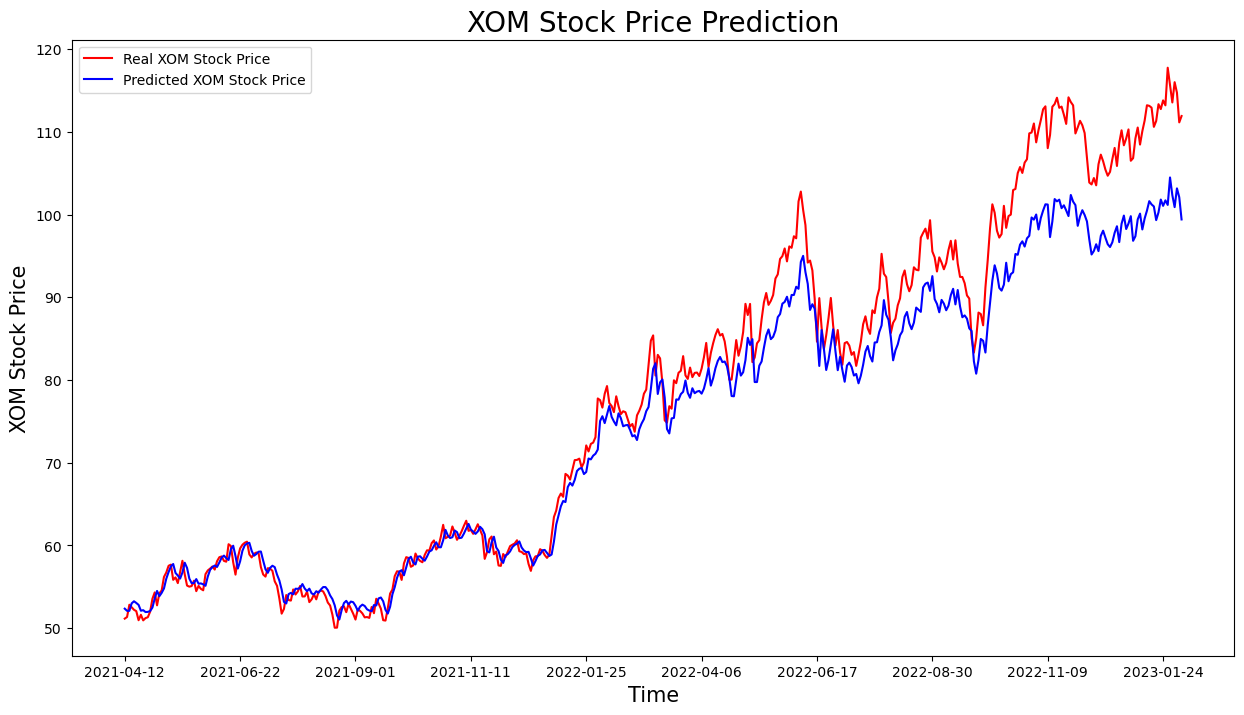

In [256]:
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(dfXOM.iloc[2081:,0], test_set_float, color='Red', label='Real XOM Stock Price')
plt.plot(dfXOM.iloc[2081:,0], predicted_stock_price, color='Blue', label='Predicted XOM Stock Price')
plt.xticks(np.arange(0,459,50))
plt.title('XOM Stock Price Prediction',fontsize=20)
plt.xlabel('Time', fontsize=15)
plt.ylabel('XOM Stock Price',fontsize=15)
plt.legend()
plt.show()

In [257]:
# Mean absolute error and mean absolute percentage error
 
errors = abs(predicted_stock_price - test_set_float)
print('Mean Absolute Error:', round(np.mean(errors), 2))

mape = (errors / test_set_float)
print('Mean Absolute Percentage Error:', round(np.mean(mape)*100, 2), '%.')

Mean Absolute Error: 3.69
Mean Absolute Percentage Error: 4.01 %.


In [258]:
# LSTM MSFT

In [259]:
#link times series daily adjusted MSFT
headers = {"User-Agent" : "Mozilla/5.0 (Macintosh; Intel Mac OS X 13_0_1) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.1 Safari/605.1.15"}

API_KEY = "LGCD1MSA9W87BCVR"
url_base = "https://www.alphavantage.co"

# unix timestamp : le nombre de seconde passée de puis le 1 Janvier 1970 00:00:00

url_suite = "/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=MSFT&outputsize=full&apikey=API_KEY"

full_url = url_base + url_suite
print(full_url)

https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=MSFT&outputsize=full&apikey=API_KEY


In [260]:
#extract times series daily adjusted MSFT
respMSFT = rq.get(full_url, headers=headers).json()
testMSFT = respMSFT['Time Series (Daily)']
days = list(testMSFT.keys())

adjustedcloseMSFT = [testMSFT[i]['5. adjusted close'] for i in testMSFT]

dfMSFT = pd.DataFrame(columns=['Date','AdjustedcloseMSFT'])
dfMSFT.iloc[:,0] = days
dfMSFT.iloc[:,1] = adjustedcloseMSFT
dfMSFT = dfMSFT.iloc[:2540,]
dfMSFT = dfMSFT[::-1]
dfMSFT

,Date,AdjustedcloseMSFT
2539,2013-01-03,22.4740605173174
2538,2013-01-04,22.0534450727731
2537,2013-01-07,22.0122082644844
2536,2013-01-08,21.8967452012762
2535,2013-01-09,22.0204556261421
...,...,...
4,2023-01-30,242.71
3,2023-01-31,247.81
2,2023-02-01,252.75
1,2023-02-02,264.6


In [261]:
# Split the sample into training and test sets
training_set = dfMSFT.iloc[:2081, 1:2].values # we want to plot 459 predicted values so 2540-459 = 2081 is the splitting row
test_set = dfMSFT.iloc[2081:, 1:2].values # test_size = 459/2540 = 18% 

In [262]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, 2081):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# X_train.shape #(2021, 60, 1)

In [263]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))
# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
64/64 [==============================] - 12s 71ms/step - loss: 0.0126
Epoch 2/100
64/64 [==============================] - 4s 69ms/step - loss: 0.0020
Epoch 3/100
64/64 [==============================] - 4s 67ms/step - loss: 0.0022
Epoch 4/100
64/64 [==============================] - 5s 71ms/step - loss: 0.0022
Epoch 5/100
64/64 [==============================] - 4s 67ms/step - loss: 0.0021
Epoch 6/100
64/64 [==============================] - 4s 70ms/step - loss: 0.0019
Epoch 7/100
64/64 [==============================] - 4s 67ms/step - loss: 0.0016
Epoch 8/100
64/64 [==============================] - 5s 71ms/step - loss: 0.0015
Epoch 9/100
64/64 [==============================] - 4s 67ms/step - loss: 0.0015
Epoch 10/100
64/64 [==============================] - 5s 79ms/step - loss: 0.0015
Epoch 11/100
64/64 [==============================] - 5s 73ms/step - loss: 0.0015
Epoch 12/100
64/64 [==============================] - 4s 68ms/step - loss: 0.0013
Epoch 13/100
64/64 [====

64/64 [==============================] - 5s 72ms/step - loss: 6.6207e-04
Epoch 98/100
64/64 [==============================] - 5s 78ms/step - loss: 6.0242e-04
Epoch 99/100
64/64 [==============================] - 4s 70ms/step - loss: 7.5182e-04
Epoch 100/100
64/64 [==============================] - 5s 71ms/step - loss: 7.5694e-04


In [264]:
# Getting the predicted stock price of MSFT
dataset_train = dfMSFT.iloc[:2081, 1:2]
dataset_test = dfMSFT.iloc[2081:, 1:2]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

X_test = []
for i in range(60, 519):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)
# (459, 60, 1)

(459, 60, 1)


In [265]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price) 

15/15 [==============================] - 2s 24ms/step


In [266]:
# Checking the shape of predicted and test_set
predicted_stock_price.shape, test_set.shape

((459, 1), (459, 1))

In [267]:
# predicted_stock_price, test_set # notice that dtype=float32, dtype=object 
# need to convert dtype of test_set from object to float32 before plotting
test_set_float = test_set.astype(float)

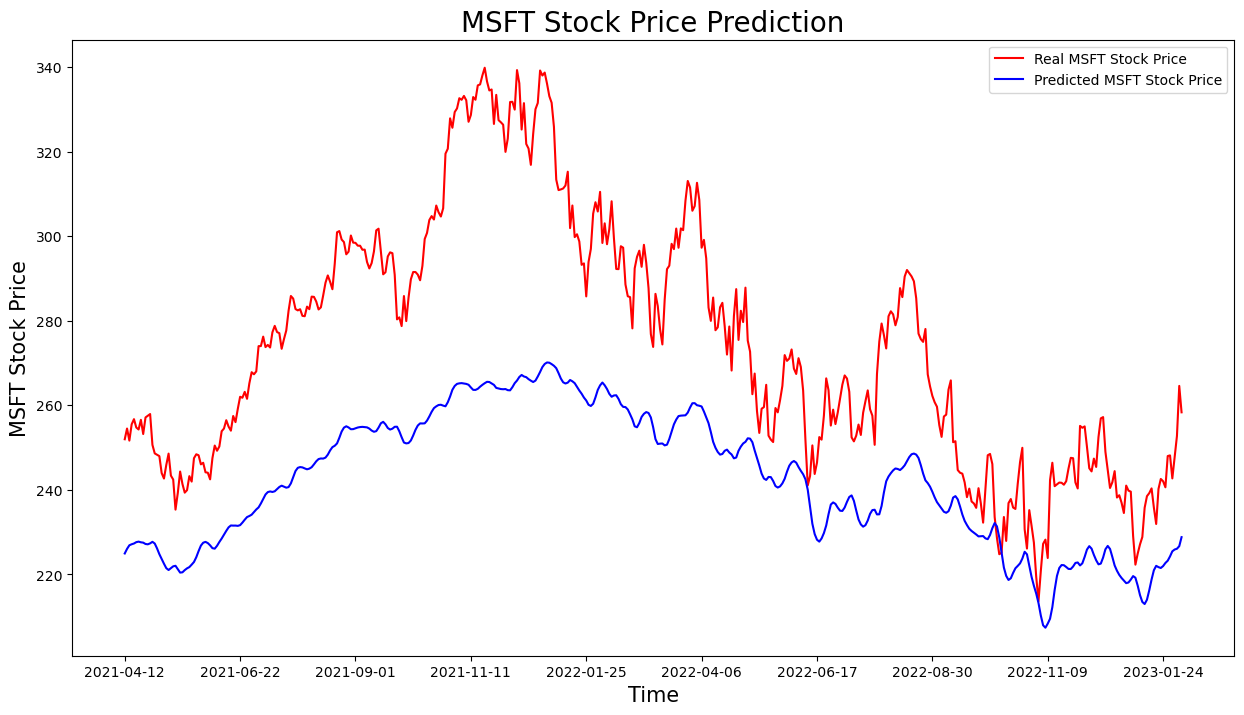

In [268]:
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(dfMSFT.iloc[2081:,0], test_set_float, color='Red', label='Real MSFT Stock Price')
plt.plot(dfMSFT.iloc[2081:,0], predicted_stock_price, color='Blue', label='Predicted MSFT Stock Price')
plt.xticks(np.arange(0,459,50))
plt.title('MSFT Stock Price Prediction',fontsize=20)
plt.xlabel('Time', fontsize=15)
plt.ylabel('MSFT Stock Price',fontsize=15)
plt.legend()
plt.show()

In [269]:
# Mean absolute error and mean absolute percentage error
 
errors = abs(predicted_stock_price - test_set_float)
print('Mean Absolute Error:', round(np.mean(errors), 2))

mape = (errors / test_set_float)
print('Mean Absolute Percentage Error:', round(np.mean(mape)*100, 2), '%.')

Mean Absolute Error: 32.09
Mean Absolute Percentage Error: 11.27 %.


In [270]:
# LSTM JPM

In [271]:
#link times series daily adjusted JPM
headers = {"User-Agent" : "Mozilla/5.0 (Macintosh; Intel Mac OS X 13_0_1) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.1 Safari/605.1.15"}

API_KEY = "LGCD1MSA9W87BCVR"
url_base = "https://www.alphavantage.co"

# unix timestamp : le nombre de seconde passée de puis le 1 Janvier 1970 00:00:00

url_suite = "/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=JPM&outputsize=full&apikey=API_KEY"

full_url = url_base + url_suite
print(full_url)

https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=JPM&outputsize=full&apikey=API_KEY


In [272]:
#extract times series daily adjusted JPM
respJPM = rq.get(full_url, headers=headers).json()
testJPM = respJPM['Time Series (Daily)']
days = list(testJPM.keys())

adjustedcloseJPM = [testJPM[i]['5. adjusted close'] for i in testJPM]

dfJPM = pd.DataFrame(columns=['Date','AdjustedcloseJPM'])
dfJPM.iloc[:,0] = days
dfJPM.iloc[:,1] = adjustedcloseJPM
dfJPM = dfJPM.iloc[:2540,]
dfJPM = dfJPM[::-1]
dfJPM

,Date,AdjustedcloseJPM
2539,2013-01-03,33.7493595429648
2538,2013-01-04,34.3475644798942
2537,2013-01-07,34.3854255518517
2536,2013-01-08,34.4535754813753
2535,2013-01-09,34.4308588382008
...,...,...
4,2023-01-30,139.13
3,2023-01-31,139.96
2,2023-02-01,139.59
1,2023-02-02,138.94


In [273]:
# Split the sample into training and test sets
training_set = dfJPM.iloc[:2081, 1:2].values # we want to plot 459 predicted values so 2540-459 = 2081 is the splitting row
test_set = dfJPM.iloc[2081:, 1:2].values # test_size = 459/2540 = 18% 

In [274]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, 2081):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# X_train.shape #(2021, 60, 1)

In [275]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))
# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
64/64 [==============================] - 12s 73ms/step - loss: 0.0178
Epoch 2/100
64/64 [==============================] - 5s 83ms/step - loss: 0.0034
Epoch 3/100
64/64 [==============================] - 4s 68ms/step - loss: 0.0033
Epoch 4/100
64/64 [==============================] - 4s 69ms/step - loss: 0.0034
Epoch 5/100
64/64 [==============================] - 5s 74ms/step - loss: 0.0031
Epoch 6/100
64/64 [==============================] - 4s 68ms/step - loss: 0.0028
Epoch 7/100
64/64 [==============================] - 7s 104ms/step - loss: 0.0024
Epoch 8/100
64/64 [==============================] - 5s 76ms/step - loss: 0.0023
Epoch 9/100
64/64 [==============================] - 7s 109ms/step - loss: 0.0022
Epoch 10/100
64/64 [==============================] - 5s 80ms/step - loss: 0.0020
Epoch 11/100
64/64 [==============================] - 5s 78ms/step - loss: 0.0022
Epoch 12/100
64/64 [==============================] - 5s 78ms/step - loss: 0.0019
Epoch 13/100
64/64 [==

64/64 [==============================] - 5s 77ms/step - loss: 7.9348e-04
Epoch 99/100
64/64 [==============================] - 6s 88ms/step - loss: 7.1743e-04
Epoch 100/100
64/64 [==============================] - 6s 100ms/step - loss: 8.0612e-04


In [276]:
# Getting the predicted stock price of JPM
dataset_train = dfJPM.iloc[:2081, 1:2]
dataset_test = dfJPM.iloc[2081:, 1:2]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

X_test = []
for i in range(60, 519):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)
# (459, 60, 1)

(459, 60, 1)


In [277]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price) 

15/15 [==============================] - 2s 29ms/step


In [278]:
# Checking the shape of predicted and test_set
predicted_stock_price.shape, test_set.shape

((459, 1), (459, 1))

In [279]:
# predicted_stock_price, test_set # notice that dtype=float32, dtype=object 
# need to convert dtype of test_set from object to float32 before plotting
test_set_float = test_set.astype(float)

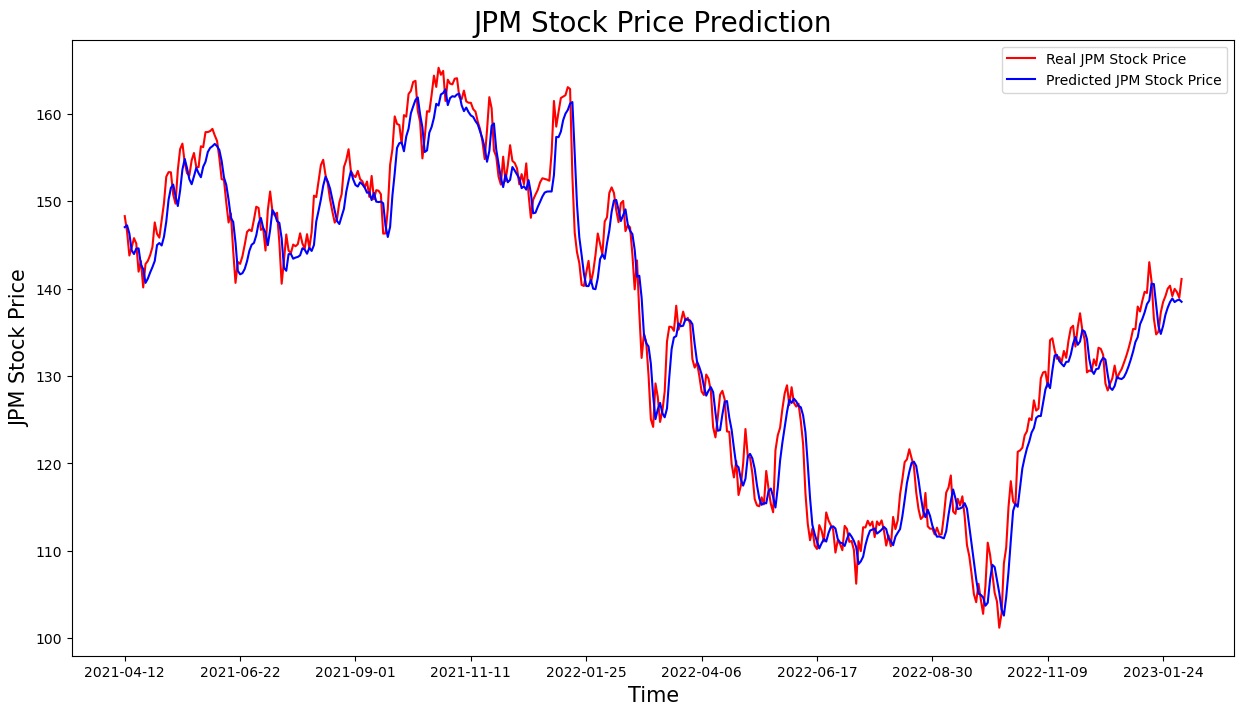

In [280]:
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(dfJPM.iloc[2081:,0], test_set_float, color='Red', label='Real JPM Stock Price')
plt.plot(dfJPM.iloc[2081:,0], predicted_stock_price, color='Blue', label='Predicted JPM Stock Price')
plt.xticks(np.arange(0,459,50))
plt.title('JPM Stock Price Prediction',fontsize=20)
plt.xlabel('Time', fontsize=15)
plt.ylabel('JPM Stock Price',fontsize=15)
plt.legend()
plt.show()

In [281]:
# Mean absolute error and mean absolute percentage error
 
errors = abs(predicted_stock_price - test_set_float)
print('Mean Absolute Error:', round(np.mean(errors), 2))

mape = (errors / test_set_float)
print('Mean Absolute Percentage Error:', round(np.mean(mape)*100, 2), '%.')

Mean Absolute Error: 2.15
Mean Absolute Percentage Error: 1.59 %.
